<a href="https://colab.research.google.com/github/mojtabaSefidi/Machine-Learning-with-Graphs/blob/main/MLG_Final_Project_100k_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# !unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


## Install Essential Packages

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Install Essential Libraries

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import pandas as pd
import torch
import seaborn as sn
sn.set()

In [8]:
geners = np.array(['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
                   'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western'], dtype=str)

values = list(range(0, len(geners)))
geners2vec = dict(zip(geners, values))

def extract_geners(text, sep='|'):
  return text.split(sep)

def geners2vector(df_geners, maper):
  result = np.zeros((len(df_geners),len(maper)), dtype='int8')
  for index, text in enumerate(df_geners):
    geners = extract_geners(text)
    for gener in geners:
      result[index][maper.get(gener)] = 1
  
  return result

In [31]:
def year_extractor(text):
  return text[text.rfind('(')+1:text.rfind(')')]

def calculate_average_rating(rating_df, movies_df, Movie_id_col='MovieID', rating_col='Rating'):
  
  rating_avg = rating_df.groupby(Movie_id_col).mean()[rating_col].round(4).to_dict()
  result = [] 
  for id in movies_df[Movie_id_col]:
    result.append(rating_avg.get(id, 0))
  movies_df['Average Rating'] = result
  return movies_df

Occupation_mapper = { 0: "other", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                     4: "college/grad student",5: "customer service", 6: "doctor/health care",
                     7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student",
                     11: "lawyer", 12: "programmer", 13: "retired", 14: "sales/marketing",
                     15: "scientist", 16: "self-employed", 17: "technician/engineer",
                     18: "tradesman/craftsman", 19: "unemployed", 20: "writer"}

def code2Occupation(occupation_col, mapper):
  return occupation_col.map(mapper)


def extract_user_feature(users_df):
  scaler = StandardScaler()
  age = scaler.fit_transform(users_df[['Age']])
  
  encoder = OneHotEncoder(handle_unknown='ignore')
  occupation = encoder.fit_transform(users_df[['Occupation']]).toarray()
  features = np.hstack((users_df[['Gender']], age, occupation))
  return torch.from_numpy(features).to(torch.float)

def extract_movie_feature(movies_df, mapper):
  scaler = StandardScaler()
  numerical = scaler.fit_transform(movies_df[['year',	'averge_rating']])
  
  categorical = geners2vector(movies_df['Genres'], mapper)
  features = np.hstack((numerical, categorical))
  return torch.from_numpy(features).to(torch.float)

def Timestamp2Date(timestamp):
  return datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

def add_age_group(df, age_col='Age'):
  bins= [0,20,25,39,60,110]
  labels = ['Teenage','Young Adult','Adult', 'Older Adult','Old']
  df['AgeGroup'] = pd.cut(df[age_col], bins=bins, labels=labels, right=False)
  return df

## Read the Dataset

In [32]:
# movies_df = pd.read_csv('/content/ml-100k/u.item', sep='|', engine='python', encoding="latin-1",
#                         names = ['MovieID', 'Movie Title', 'Release Date', 'video release date','IMDbURL',
#                                  'Unknown','Action','Adventure','Animation', 'Childrens','Comedy',
#                                  'Crime','Documentary','Drama','Fantasy', 'Film-Noir','Horror',
#                                  'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'])

# rating_df = pd.read_csv('/content/ml-100k/u.data', sep='\t', engine='python', encoding="latin-1",
#                         names=['UserID','MovieID','Rating','Timestamp'])

# users_df = pd.read_csv('/content/ml-100k/u.user', sep='|', engine='python', encoding="latin-1",
#                        names=['UserID','Age', 'Gender', 'Occupation','Zipcode'])

# movies_df.to_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/movies_df.csv', index=False)
# rating_df.to_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/rating_df.csv', index=False)
# users_df.to_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/users_df.csv', index=False)

In [33]:
movies_df = pd.read_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/movies_df.csv')
rating_df = pd.read_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/rating_df.csv')
users_df = pd.read_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/users_df.csv')
movies_df.shape, rating_df.shape, users_df.shape


((1682, 24), (100000, 4), (943, 5))

In [34]:
rating_df

,UserID,MovieID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [35]:
def remove_movies(rating_df, movies_df, title_col='Movie Title', movie_id_col='MovieID'):
  unknown_movies = movies_df[movies_df[title_col]=='unknown'][movie_id_col]
  rating_df = rating_df[~rating_df[movie_id_col].isin(unknown_movies)]
  movies_df = movies_df[~movies_df[movie_id_col].isin(unknown_movies)]
  return rating_df, movies_df

rating_df, movies_df = remove_movies(rating_df, movies_df)


In [36]:
movies_df.drop(['video release date', 'IMDbURL'], axis=1, inplace=True)
movies_df['Release Date'] = pd.to_datetime(movies_df['Release Date'])
movies_df['Release Year'] = movies_df['Release Date'].dt.year
movies_df['Release Month'] = movies_df['Release Date'].dt.month
movies_df = movies_df.sort_values(by=['Release Date']).reset_index(drop=True)
movies_df = calculate_average_rating(rating_df, movies_df)
movies_df.tail(2).T

,1679,1680
MovieID,1432,315
Movie Title,"Mighty, The (1998)",Apt Pupil (1998)
Release Date,1998-10-09 00:00:00,1998-10-23 00:00:00
Unknown,0,0
Action,0,0
Adventure,0,0
Animation,0,0
Childrens,0,0
Comedy,0,0
Crime,0,0


In [37]:
users_df = add_age_group(users_df)
users_df

,UserID,Age,Gender,Occupation,Zipcode,AgeGroup
0,1,24,M,technician,85711,Young Adult
1,2,53,F,other,94043,Older Adult
2,3,23,M,writer,32067,Young Adult
3,4,24,M,technician,43537,Young Adult
4,5,33,F,other,15213,Adult
...,...,...,...,...,...,...
938,939,26,F,student,33319,Adult
939,940,32,M,administrator,02215,Adult
940,941,20,M,student,97229,Young Adult
941,942,48,F,librarian,78209,Older Adult


In [38]:
rating_df.loc[:,'Timestamp'] = rating_df.loc[:,'Timestamp'].apply(Timestamp2Date)
rating_df.sort_values(by= 'Timestamp', inplace=True)
rating_df.reset_index(drop=True, inplace=True)
rating_df

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,UserID,MovieID,Rating,Timestamp
0,259,255,4,1997-09-20 03:05:10
1,259,286,4,1997-09-20 03:05:27
2,259,298,4,1997-09-20 03:05:54
3,259,185,4,1997-09-20 03:06:21
4,259,173,4,1997-09-20 03:07:23
...,...,...,...,...
99986,729,689,4,1998-04-22 23:10:38
99987,729,300,4,1998-04-22 23:10:38
99988,729,748,4,1998-04-22 23:10:38
99989,729,313,3,1998-04-22 23:10:38


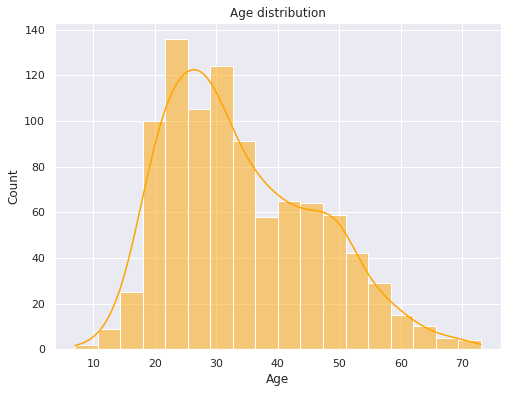

In [65]:
plt.figure(figsize=(8,6))
plt.title('Age Distribution')
sn.histplot(data=users_df, x="Age", color='orange', kde=True, alpha=0.5)

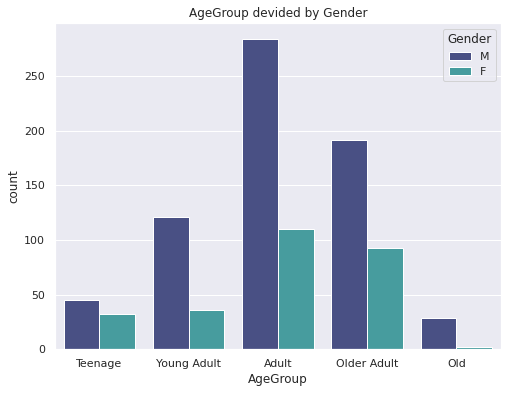

In [53]:
plt.figure(figsize=(8,6))
plt.title('AgeGroup devided by Gender')
sn.countplot(data=users_df, x='AgeGroup', hue='Gender', palette='mako')

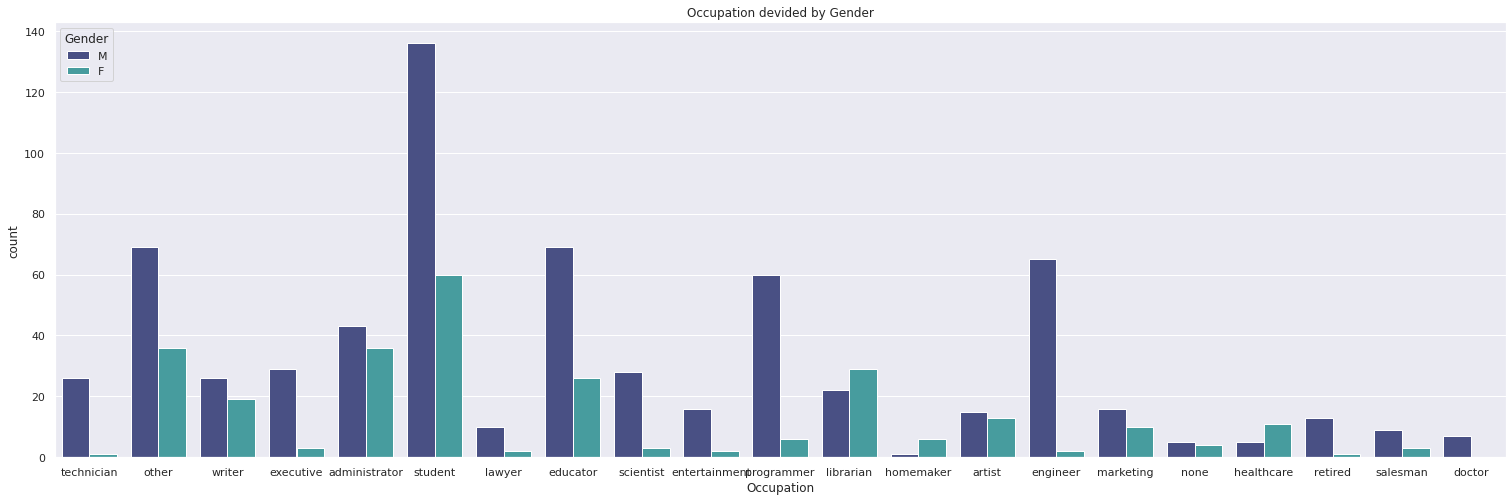

In [55]:
plt.figure(figsize=(26,8))
plt.title('Occupation devided by Gender')
sn.countplot(data=users_df, x='Occupation', hue='Gender', palette='mako')

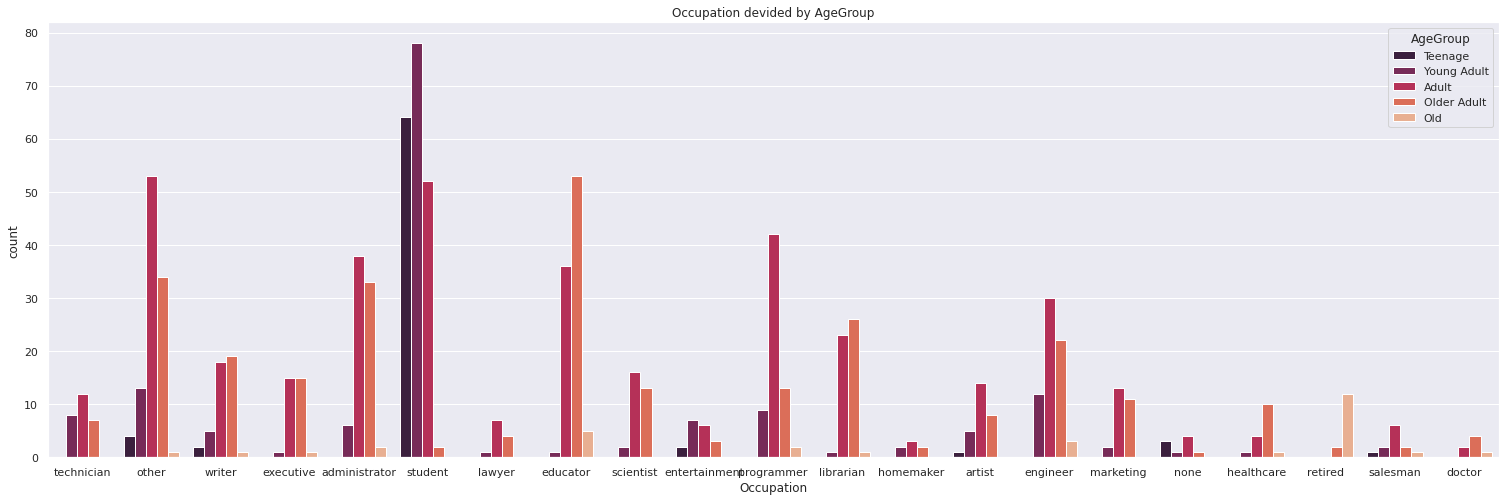

In [52]:
plt.figure(figsize=(26,8))
plt.title('Occupation devided by AgeGroup')
sn.countplot(data=users_df, x='Occupation', hue='AgeGroup', palette='rocket')

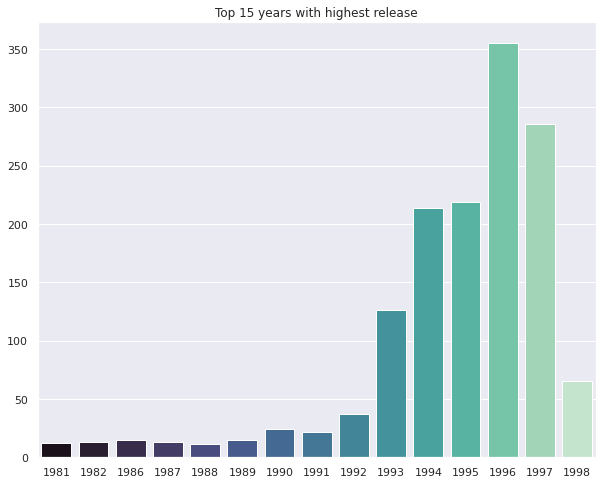

In [240]:
x = movies_df['Release Year'].value_counts()[:15]

plt.figure(figsize=(10,8))
plt.title('Top 15 years with highest release')
sn.barplot(x=x.index, y=x.values, palette='mako')

In [116]:
# c = ['Release Year', 'Movie Title']
# top2 = movies_df.groupby(c)['Average Rating'].nlargest(2)
# top2
highest_Ratings = pd.DataFrame(movies_df[['Release Year', 'Movie Title', 'Average Rating']].groupby('Release Year')['Average Rating'].nlargest(2))
highest_Ratings.style.background_gradient(cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))

In [115]:
lowest_Ratings = pd.DataFrame(movies_df[['Release Year', 'Movie Title', 'Average Rating']].groupby('Release Year')['Average Rating'].nsmallest(2))
lowest_Ratings.style.background_gradient(cmap=sn.light_palette("seagreen", as_cmap=True))

In [216]:
top_k = 5
genres  = np.array(['Action','Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime',
                'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror','Musical',
                'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War','Western'],
      dtype=object)

def genres_info(movies_df, genres, top_k=5):
  highest = np.zeros(shape=(len(genres)*top_k, 4), dtype=object)
  lowest = np.zeros(shape=(len(genres)*top_k, 4),  dtype=object)
  avg_rating = np.zeros(len(genres))
  for i, genre in enumerate(genres):
    df = movies_df[movies_df[genre]==1][['Movie Title', 'MovieID', genre,'Average Rating']]
    avg_rating[i]= df['Average Rating'].mean()
    df[genre]=genre
    high = df.sort_values(by='Average Rating', ascending=False).reset_index(drop=True).iloc[:top_k,:].to_numpy()
    low = df.sort_values(by='Average Rating', ascending=True).reset_index(drop=True).iloc[:top_k,:].to_numpy()
    
    start, end = i*top_k, (i+1)*top_k
    highest[start:end] = high
    lowest[start:end] = low
  return highest, lowest, avg_rating


highest, lowest, avg_rating = genres_info(movies_df, genres)
highest_df = pd.DataFrame(highest, columns=['Movie Title', 'MovieID','Genre','Average Rating'])
highest_df['Average Rating'] = highest_df['Average Rating'].astype(float)
lowest_df = pd.DataFrame(lowest, columns=['Movie Title', 'MovieID','Genre','Average Rating'])
lowest_df['Average Rating'] = lowest_df['Average Rating'].astype(float)
avg_rating_df = pd.DataFrame(avg_rating, index=genres, columns=['Average Rating'])

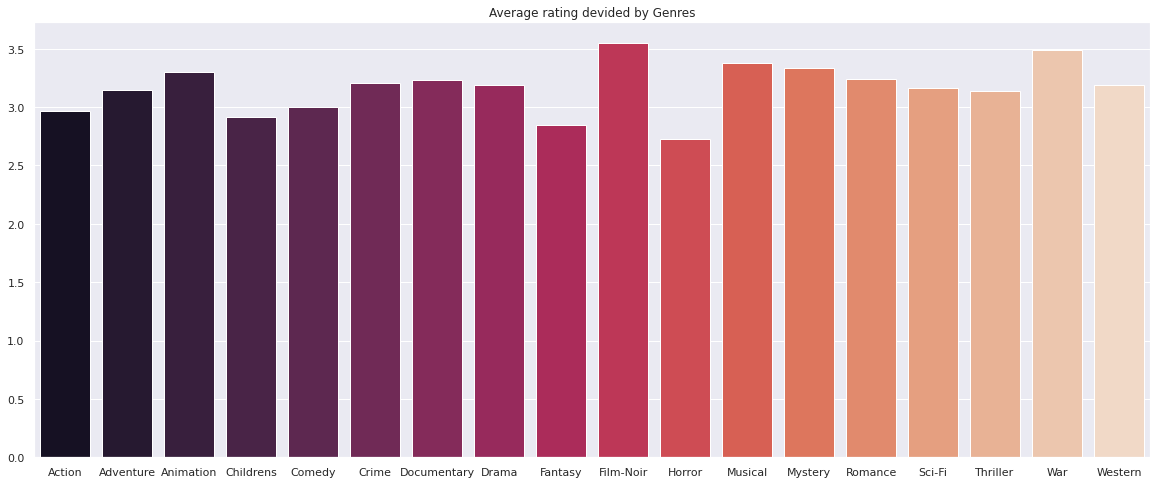

In [217]:
plt.figure(figsize=(20,8))
plt.title('Average rating devided by Genres')
sn.barplot(x=genres, y=avg_rating, palette='rocket')

,MovieID,Title,Genres,year,averge_rating
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,4.1468
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,3.2011
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,3.0167
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,2.7294
4,5,Father of the Bride Part II (1995),Comedy,1995,3.0068
...,...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,2000,3.6357
3879,3949,Requiem for a Dream (2000),Drama,2000,4.1151
3880,3950,Tigerland (2000),Drama,2000,3.6667
3881,3951,Two Family House (2000),Drama,2000,3.9000


In [ ]:
users_df['Gender'] = pd.get_dummies(users_df['Gender'], drop_first=True)
users_df['Occupation'] = code2Occupation(users_df['Occupation'], Occupation_mapper)
users_df

,UserID,Gender,Age,Occupation,Zipcode
0,1,0,1,K-12 student,48067
1,2,1,56,self-employed,70072
2,3,1,25,scientist,55117
3,4,1,45,executive/managerial,02460
4,5,1,25,writer,55455
...,...,...,...,...,...
6035,6036,0,25,scientist,32603
6036,6037,0,45,academic/educator,76006
6037,6038,0,56,academic/educator,14706
6038,6039,0,45,other,01060


In [ ]:
rating_df['Timestamp'] = rating_df['Timestamp'].apply(Timestamp2Date)
rating_df.sort_values(by=['Timestamp'], inplace=True)
rating_df.reset_index(drop=True, inplace=True)
rating_df

,UserID,MovieID,Rating,Timestamp
0,6040,858,4,2000-04-25 23:05:32
1,6040,2384,4,2000-04-25 23:05:54
2,6040,593,5,2000-04-25 23:05:54
3,6040,1961,4,2000-04-25 23:06:17
4,6040,2019,5,2000-04-25 23:06:17
...,...,...,...,...
1000204,4958,2399,1,2003-02-28 17:45:38
1000205,4958,1407,5,2003-02-28 17:47:23
1000206,4958,3264,4,2003-02-28 17:49:08
1000207,4958,2634,3,2003-02-28 17:49:08


## Data Analysis

In [ ]:
user_features = extract_user_feature(users_df)
movie_features = extract_movie_feature(movies_df, extract_movie_feature)
movie_features, user_features

(tensor([[ 0.5288,  1.1198,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.5288,  0.1165,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.5288, -0.0791,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.8248,  0.6105,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.8248,  0.8580,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.8248,  0.7317,  0.0000,  ...,  1.0000,  0.0000,  0.0000]]),
 tensor([[ 0.0000, -2.2985,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  1.9667,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000, -0.4373,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  1.9667,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.1137,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000, -0.4373,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]))

In [ ]:
(user_features[0] * movie_features[0])

RuntimeError: ignored

In [ ]:
def generate_edge(rating_df, rating_threshold=3.5):

  graph_edges = [[],[]]
  edge_weight = []

  for userID, movieID, rating in rating_df[['UserID','MovieID','Rating']].itertuples(index=False):
    if rating >= rating_threshold:
      graph_edges[0].append(userID)
      graph_edges[1].append(movieID)
      edge_weight.append(rating)
    
    else:
      continue
  
  return torch.tensor(graph_edges, dtype=torch.long), torch.tensor(edge_weight, dtype=torch.long)

In [ ]:
user2movie_edge, user2movie_edge_weight = generate_edge(rating_df)
user2movie_edge.shape, user2movie_edge_weight.shape

(torch.Size([2, 575281]), torch.Size([575281]))

In [ ]:
dataset = HeteroData()

dataset["user"].node_id = torch.from_numpy(users_df['UserID'].unique()).to(torch.int16)
dataset["movie"].node_id = torch.from_numpy(movies_df['MovieID'].unique()).to(torch.int16)

dataset["movie"].x = movie_features
dataset["user"].x = user_features
dataset["user", "rates", "movie"].edge_index = user2movie_edge
dataset["user", "rates", "movie"].edge_weight = user2movie_edge_weight

dataset = transforms.ToUndirected()(dataset)

In [ ]:
dataset

HeteroData(
  user={
    node_id=[6040],
    x=[6040, 23]
  },
  movie={
    node_id=[3883],
    x=[3883, 20]
  },
  (user, rates, movie)={
    edge_index=[2, 1000209],
    edge_weight=[1000209]
  },
  (movie, rev_rates, user)={
    edge_index=[2, 1000209],
    edge_weight=[1000209]
  }
)

In [ ]:
transform = transforms.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"), 
)

train_dataset, validation_dataset, test_dataset = transform(dataset)

In [ ]:
train_dataset["user", "rates", "movie"].edge_label_index

tensor([[2768, 3735, 3025,  ..., 2124, 4365, 3625],
        [  50, 2111, 1035,  ...,  471, 3760, 3246]])

In [ ]:
train_dataset, validation_dataset, test_dataset

(HeteroData(
   user={
     node_id=[6040],
     x=[6040, 23]
   },
   movie={
     node_id=[3883],
     x=[3883, 20]
   },
   (user, rates, movie)={
     edge_index=[2, 560119],
     edge_weight=[560119],
     edge_label=[240050],
     edge_label_index=[2, 240050]
   },
   (movie, rev_rates, user)={
     edge_index=[2, 560119],
     edge_weight=[560119]
   }
 ), HeteroData(
   user={
     node_id=[6040],
     x=[6040, 23]
   },
   movie={
     node_id=[3883],
     x=[3883, 20]
   },
   (user, rates, movie)={
     edge_index=[2, 800169],
     edge_weight=[800169],
     edge_label=[300060],
     edge_label_index=[2, 300060]
   },
   (movie, rev_rates, user)={
     edge_index=[2, 800169],
     edge_weight=[800169]
   }
 ), HeteroData(
   user={
     node_id=[6040],
     x=[6040, 23]
   },
   movie={
     node_id=[3883],
     x=[3883, 20]
   },
   (user, rates, movie)={
     edge_index=[2, 900189],
     edge_weight=[900189],
     edge_label=[300060],
     edge_label_index=[2, 300060]
   }

In [ ]:

# Define seed edges:
edge_label_index = train_dataset["user", "rates", "movie"].edge_label_index
edge_label = train_dataset["user", "rates", "movie"].edge_label
train_loader = LinkNeighborLoader(
    data=train_dataset,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

In [ ]:
train_loader

LinkNeighborLoader()

In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user, x_movie, edge_label_index):
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.movie_lin = torch.nn.Linear(20, hidden_channels)
        self.user_emb = torch.nn.Embedding(dataset["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(dataset["movie"].num_nodes, hidden_channels)
        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=dataset.metadata())
        self.classifier = Classifier()
    def forward(self, data: HeteroData):
        x_dict = {
          "user": self.user_emb(dataset["user"].node_id),
          "movie": self.movie_lin(dataset["movie"].x) + self.movie_emb(dataset["movie"].node_id),
        } 
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, dataset.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )
        return pred
        
model = Model(hidden_channels=64)

In [ ]:
import tqdm
import torch.nn.functional as F
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Device: '{device}'")
# model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1, 6):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        # sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

  0%|          | 0/1876 [00:00<?, ?it/s]

In [ ]:
for batch, data in enumerate(train_data_loader):
    print(f'Batch {batch + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Streaming output truncated to the last 5000 lines.
Batch 30:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1660], edge_attr=[1660, 3], x=[770, 9], y=[32, 1], num_nodes=770, batch=[770], ptr=[33])

Batch 31:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1804], edge_attr=[1804, 3], x=[840, 9], y=[32, 1], num_nodes=840, batch=[840], ptr=[33])

Batch 32:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1920], edge_attr=[1920, 3], x=[901, 9], y=[32, 1], num_nodes=901, batch=[901], ptr=[33])

Batch 33:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1444], edge_attr=[1444, 3], x=[677, 9], y=[32, 1], num_nodes=677, batch=[677], ptr=[33])

Batch 34:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1682], edge_attr=[1682, 3], x=[778, 9], y=[32, 1], num_nodes=778, batch=[778], ptr=[33])

Batch 35:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1702], edge_attr=[1702, 3], x=[798, 9

## Split the Dataset

In [ ]:
def split_data(dataset, train_split_percentage):
  cut_index = int(len(dataset) * train_split_percentage)
  dataset = dataset.shuffle()
  return dataset[:cut_index], dataset[cut_index:]

In [ ]:
train_dataset, test_dataset = split_data(dataset, train_split_percentage=0.8)
print(f'Number of graphs in the Train Dataset: {len(train_dataset)}')
print(f'Number of graphs in the Test Dataset: {len(test_dataset)}')

Number of graphs in the Train Dataset: 32901
Number of graphs in the Test Dataset: 8226


## Batch Generator

In [ ]:
def batch_generator(train_dataset, test_dataset, batch_size, shuffle=True):
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
  test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
  return train_data_loader, test_data_loader

In [ ]:
train_data_loader, test_data_loader =  batch_generator(train_dataset, test_dataset, batch_size=64)

for batch, data in enumerate(train_data_loader):
    print(f'Batch {batch + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()


Batch 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3566], edge_attr=[3566, 3], x=[1642, 9], y=[64, 1], num_nodes=1642, batch=[1642], ptr=[65])

Batch 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3630], edge_attr=[3630, 3], x=[1695, 9], y=[64, 1], num_nodes=1695, batch=[1695], ptr=[65])

Batch 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3446], edge_attr=[3446, 3], x=[1603, 9], y=[64, 1], num_nodes=1603, batch=[1603], ptr=[65])

Batch 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3584], edge_attr=[3584, 3], x=[1670, 9], y=[64, 1], num_nodes=1670, batch=[1670], ptr=[65])

Batch 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3494], edge_attr=[3494, 3], x=[1622, 9], y=[64, 1], num_nodes=1622, batch=[1622], ptr=[65])

Batch 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3522], edge_attr=[3522, 3], x=[1629, 9], y=[64, 1], num_nodes=1629, batch=[1629

## Single sample of Batch 3

In [ ]:
data[0]

Data(edge_index=[2, 46], edge_attr=[46, 3], x=[22, 9], y=[1, 1], num_nodes=22)

In [ ]:
class GCN_Add_Pooling(torch.nn.Module):
    
    def __init__(self, hidden_channels, aggregation):
        super(GCN_Add_Pooling, self).__init__()
        torch.manual_seed(12345)
        if type(aggregation) != list:
          self.conv1 = GCNConv(dataset.num_node_features, hidden_channels, aggr=aggregation)
          self.conv2 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.conv3 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.conv4 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.lin = Linear(hidden_channels, dataset.num_classes)
        else:
          i=1
          self.conv1 = GCNConv(dataset.num_node_features, hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          i+=1
          self.conv2 = GCNConv(hidden_channels*(len(aggregation)**(i)), hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          i+=1
          self.conv3 = GCNConv(hidden_channels*(len(aggregation)**(i)), hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          i+=1
          self.conv4 = GCNConv(hidden_channels*(len(aggregation)**(i)), hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          self.lin = Linear(hidden_channels*(len(aggregation)**(i+1)), dataset.num_classes)
        
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x


In [ ]:
class Graph_Sage(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Graph_Sage, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = SAGEConv(dataset.num_node_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)

        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)


        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [ ]:
class Graph_Conv(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Graph_Conv, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        
        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [ ]:
class Graph_Conv3(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Graph_Conv3, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        
        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [ ]:
class Leaning_Evaluation(torch.nn.Module):
    def __init__(
        self,
        model,
        learning_rate=0.006,
        best_results=[0, 0, 0],
        ):
      
      super().__init__()
      self.model = model
      self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
      self.criterion = torch.nn.CrossEntropyLoss()
      self.best_results = best_results
    
    def train(self, data_loader):
        self.model.train()

        for data in data_loader:
            out = self.model(data.x, data.edge_index, data.batch)
            loss = self.criterion(out, data.y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

    def evaluate(self, data_loader):
        self.model.eval()

        correct, loss = 0, 0
        for data in data_loader:
            out = self.model(data.x, data.edge_index, data.batch).float()
            loss += self.criterion(out, data.y)  
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
        return correct / len(data_loader.dataset), loss/ len(data_loader.dataset)

    def train_and_evaluate(self, train_data_loader, test_data_loader, n_epochs=200):
      
      list_train_acc, list_train_loss, list_test_acc, list_test_loss = [], [], [], []
      print('Train and Evaluation started...')
      for epoch in range(1, n_epochs+1):
          self.train(train_data_loader)
          
          train_accuracy, train_loss = self.evaluate(train_data_loader)
          list_train_acc.append(train_accuracy)
          list_train_loss.append(float(train_loss.detach()))
          
          test_accuracy, test_loss = self.evaluate(test_data_loader)
          if self.best_results[-1] + self.best_results[1] < test_accuracy + train_accuracy :
            self.best_results[0], self.best_results[1], self.best_results[-1] = epoch, train_accuracy ,test_accuracy

          list_test_acc.append(test_accuracy)
          list_test_loss.append(float(test_loss.detach()))

          print(f'Epoch: {epoch:03d}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')
      
      print('---------------------------------------------------')
      print('Train and Evaluation finished...')
      print(f'Best Results of the model : Epoch: {self.best_results[0]:03d}, Train Accuracy: {self.best_results[1]:.4f}, Test Accuracy: {self.best_results[-1]:.4f}')
      return list_train_acc, list_train_loss, list_test_acc, list_test_loss
      

### Aggregation Function = add

In [ ]:
model = GCN_Add_Pooling(hidden_channels=64, aggregation='add')
print(model)

GCN_Add_Pooling(
  (conv1): GCNConv(9, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_GCN_add = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_add.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=100)

Train and Evaluation started...


RuntimeError: ignored

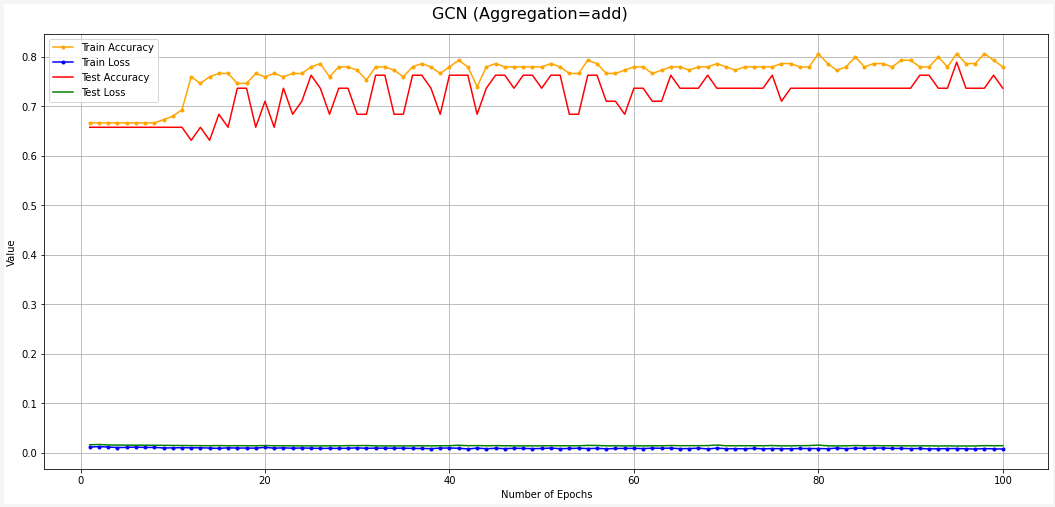

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=100, title='GCN (Aggregation=add)')

### Aggregation Function = Max

In [ ]:
model = GCN_Add_Pooling(hidden_channels=64, aggregation='max')
print(model)

GCN_Add_Pooling(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_GCN_max = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_max.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=100)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6667, Train Loss: 0.0118, Test Accuracy: 0.6579, Test Loss: 0.0162
Epoch: 002, Train Accuracy: 0.6667, Train Loss: 0.0121, Test Accuracy: 0.6579, Test Loss: 0.0162
Epoch: 003, Train Accuracy: 0.6667, Train Loss: 0.0120, Test Accuracy: 0.6579, Test Loss: 0.0164
Epoch: 004, Train Accuracy: 0.6667, Train Loss: 0.0109, Test Accuracy: 0.6579, Test Loss: 0.0163
Epoch: 005, Train Accuracy: 0.6667, Train Loss: 0.0110, Test Accuracy: 0.6579, Test Loss: 0.0160
Epoch: 006, Train Accuracy: 0.6667, Train Loss: 0.0120, Test Accuracy: 0.6579, Test Loss: 0.0159
Epoch: 007, Train Accuracy: 0.6667, Train Loss: 0.0115, Test Accuracy: 0.6579, Test Loss: 0.0159
Epoch: 008, Train Accuracy: 0.6667, Train Loss: 0.0117, Test Accuracy: 0.6579, Test Loss: 0.0159
Epoch: 009, Train Accuracy: 0.6667, Train Loss: 0.0107, Test Accuracy: 0.6579, Test Loss: 0.0158
Epoch: 010, Train Accuracy: 0.6667, Train Loss: 0.0109, Test Accuracy: 0.6579, Test Loss: 0.015

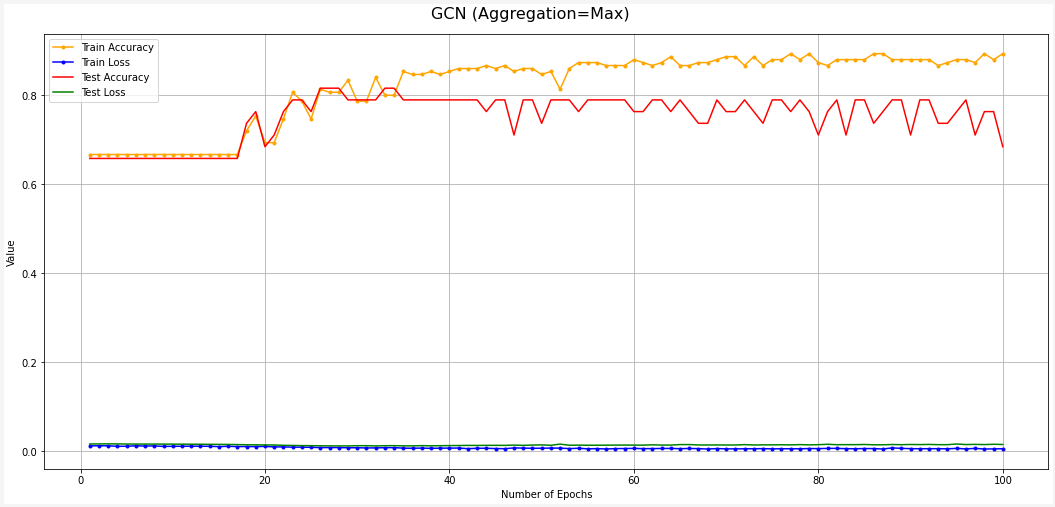

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=100, title='GCN (Aggregation=Max)')

### Aggregation Function = Min

In [ ]:
model = GCN_Add_Pooling(hidden_channels=64, aggregation='mean')
print(model)

GCN_Add_Pooling(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_GCN_mean = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_mean.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=100)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6667, Train Loss: 0.0119, Test Accuracy: 0.6579, Test Loss: 0.0162
Epoch: 002, Train Accuracy: 0.6667, Train Loss: 0.0120, Test Accuracy: 0.6579, Test Loss: 0.0162
Epoch: 003, Train Accuracy: 0.6667, Train Loss: 0.0120, Test Accuracy: 0.6579, Test Loss: 0.0164
Epoch: 004, Train Accuracy: 0.6667, Train Loss: 0.0109, Test Accuracy: 0.6579, Test Loss: 0.0164
Epoch: 005, Train Accuracy: 0.6667, Train Loss: 0.0110, Test Accuracy: 0.6579, Test Loss: 0.0161
Epoch: 006, Train Accuracy: 0.6667, Train Loss: 0.0120, Test Accuracy: 0.6579, Test Loss: 0.0160
Epoch: 007, Train Accuracy: 0.6667, Train Loss: 0.0115, Test Accuracy: 0.6579, Test Loss: 0.0159
Epoch: 008, Train Accuracy: 0.6667, Train Loss: 0.0118, Test Accuracy: 0.6579, Test Loss: 0.0160
Epoch: 009, Train Accuracy: 0.6667, Train Loss: 0.0108, Test Accuracy: 0.6579, Test Loss: 0.0159
Epoch: 010, Train Accuracy: 0.6667, Train Loss: 0.0110, Test Accuracy: 0.6579, Test Loss: 0.015

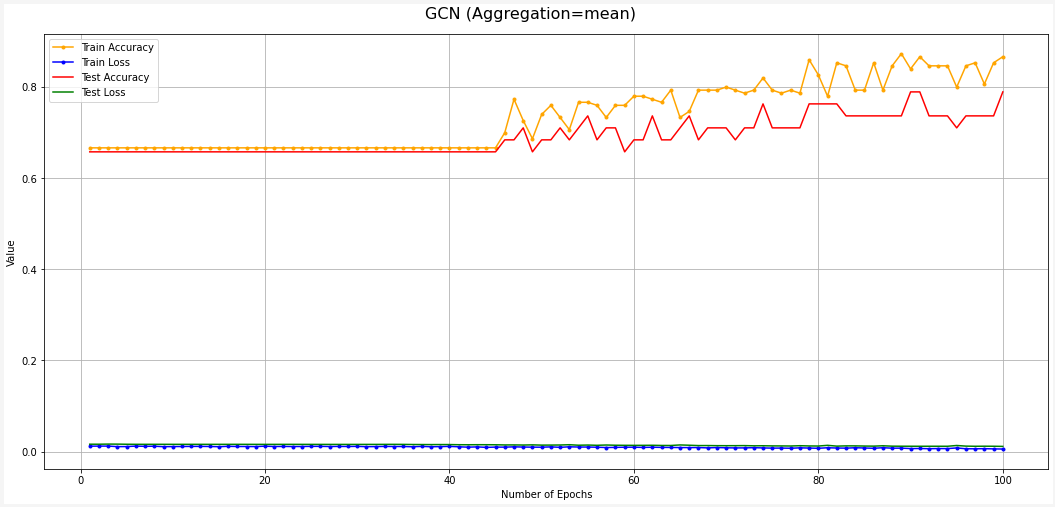

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=100, title='GCN (Aggregation=mean)')

### Aggregation Function = [Add, Max, Min]

In [ ]:
model = GCN_Add_Pooling(hidden_channels=8, aggregation=['add','mean','max'])
print(model)

GCN_Add_Pooling(
  (conv1): GCNConv(7, 24)
  (conv2): GCNConv(72, 72)
  (conv3): GCNConv(216, 216)
  (conv4): GCNConv(648, 648)
  (lin): Linear(in_features=1944, out_features=2, bias=True)
)


In [ ]:
evaluate_GCN_all = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_all.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=100)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6667, Train Loss: 0.0109, Test Accuracy: 0.6579, Test Loss: 0.0155
Epoch: 002, Train Accuracy: 0.6667, Train Loss: 0.0112, Test Accuracy: 0.6579, Test Loss: 0.0155
Epoch: 003, Train Accuracy: 0.6667, Train Loss: 0.0104, Test Accuracy: 0.6579, Test Loss: 0.0147
Epoch: 004, Train Accuracy: 0.6867, Train Loss: 0.0100, Test Accuracy: 0.6842, Test Loss: 0.0141
Epoch: 005, Train Accuracy: 0.7667, Train Loss: 0.0091, Test Accuracy: 0.7368, Test Loss: 0.0134
Epoch: 006, Train Accuracy: 0.7800, Train Loss: 0.0088, Test Accuracy: 0.7105, Test Loss: 0.0136
Epoch: 007, Train Accuracy: 0.7733, Train Loss: 0.0082, Test Accuracy: 0.7368, Test Loss: 0.0143
Epoch: 008, Train Accuracy: 0.7733, Train Loss: 0.0082, Test Accuracy: 0.7105, Test Loss: 0.0140
Epoch: 009, Train Accuracy: 0.8133, Train Loss: 0.0073, Test Accuracy: 0.7368, Test Loss: 0.0138
Epoch: 010, Train Accuracy: 0.7733, Train Loss: 0.0096, Test Accuracy: 0.7368, Test Loss: 0.014

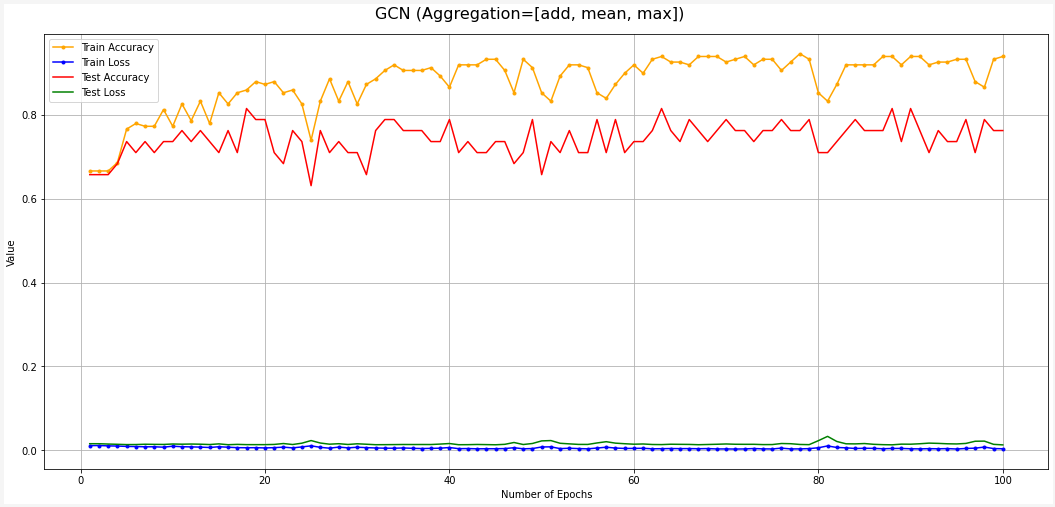

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=100, title='GCN (Aggregation=[add, mean, max])')

### GraphSage

In [ ]:
model = Graph_Sage(hidden_channels=64)
print(model)

Graph_Sage(
  (conv1): SAGEConv(7, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (conv3): SAGEConv(64, 64, aggr=mean)
  (conv4): SAGEConv(64, 64, aggr=mean)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_GraphSage = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GraphSage.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=150)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6667, Train Loss: 0.0123, Test Accuracy: 0.6579, Test Loss: 0.0175
Epoch: 002, Train Accuracy: 0.7000, Train Loss: 0.0122, Test Accuracy: 0.6579, Test Loss: 0.0165
Epoch: 003, Train Accuracy: 0.6667, Train Loss: 0.0146, Test Accuracy: 0.6579, Test Loss: 0.0206
Epoch: 004, Train Accuracy: 0.6667, Train Loss: 0.0129, Test Accuracy: 0.6579, Test Loss: 0.0193
Epoch: 005, Train Accuracy: 0.6667, Train Loss: 0.0111, Test Accuracy: 0.6579, Test Loss: 0.0155
Epoch: 006, Train Accuracy: 0.6733, Train Loss: 0.0108, Test Accuracy: 0.6579, Test Loss: 0.0155
Epoch: 007, Train Accuracy: 0.6667, Train Loss: 0.0108, Test Accuracy: 0.6579, Test Loss: 0.0158
Epoch: 008, Train Accuracy: 0.6667, Train Loss: 0.0130, Test Accuracy: 0.6579, Test Loss: 0.0169
Epoch: 009, Train Accuracy: 0.6733, Train Loss: 0.0102, Test Accuracy: 0.6579, Test Loss: 0.0150
Epoch: 010, Train Accuracy: 0.7267, Train Loss: 0.0105, Test Accuracy: 0.6842, Test Loss: 0.014

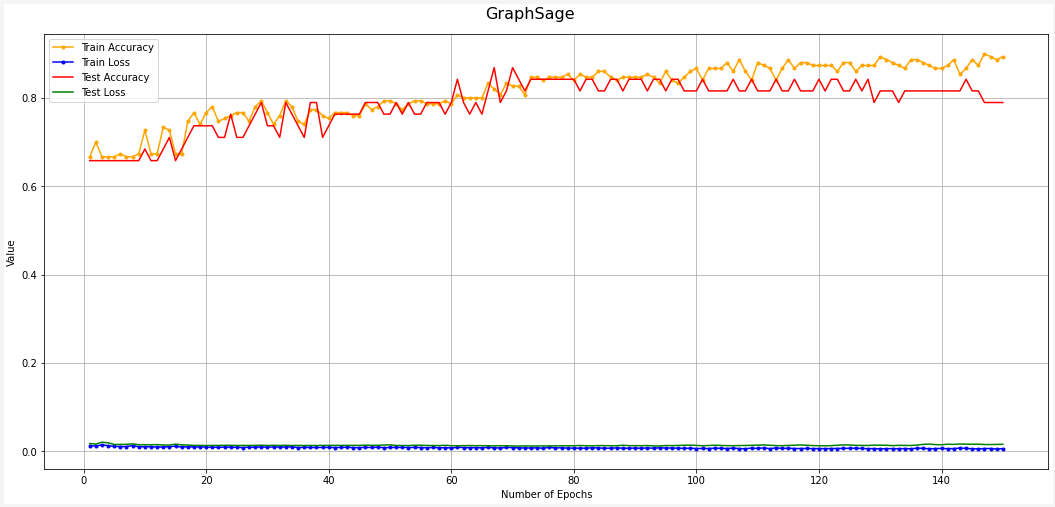

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=150, title='GraphSage')

### GraphConv

In [ ]:
model = Graph_Conv(hidden_channels=64)
print(model)

Graph_Conv(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (conv4): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_GraphConv = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GraphConv.train_and_evaluate(train_data_loader, test_data_loader,  n_epochs=150)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6667, Train Loss: 0.0309, Test Accuracy: 0.6579, Test Loss: 0.0453
Epoch: 002, Train Accuracy: 0.7133, Train Loss: 0.0099, Test Accuracy: 0.6316, Test Loss: 0.0144
Epoch: 003, Train Accuracy: 0.6733, Train Loss: 0.0169, Test Accuracy: 0.6579, Test Loss: 0.0250
Epoch: 004, Train Accuracy: 0.8000, Train Loss: 0.0101, Test Accuracy: 0.7105, Test Loss: 0.0153
Epoch: 005, Train Accuracy: 0.6667, Train Loss: 0.0115, Test Accuracy: 0.6316, Test Loss: 0.0172
Epoch: 006, Train Accuracy: 0.6733, Train Loss: 0.0148, Test Accuracy: 0.6579, Test Loss: 0.0242
Epoch: 007, Train Accuracy: 0.7933, Train Loss: 0.0075, Test Accuracy: 0.7105, Test Loss: 0.0127
Epoch: 008, Train Accuracy: 0.7933, Train Loss: 0.0099, Test Accuracy: 0.7105, Test Loss: 0.0166
Epoch: 009, Train Accuracy: 0.8200, Train Loss: 0.0078, Test Accuracy: 0.7368, Test Loss: 0.0122
Epoch: 010, Train Accuracy: 0.7600, Train Loss: 0.0082, Test Accuracy: 0.6842, Test Loss: 0.012

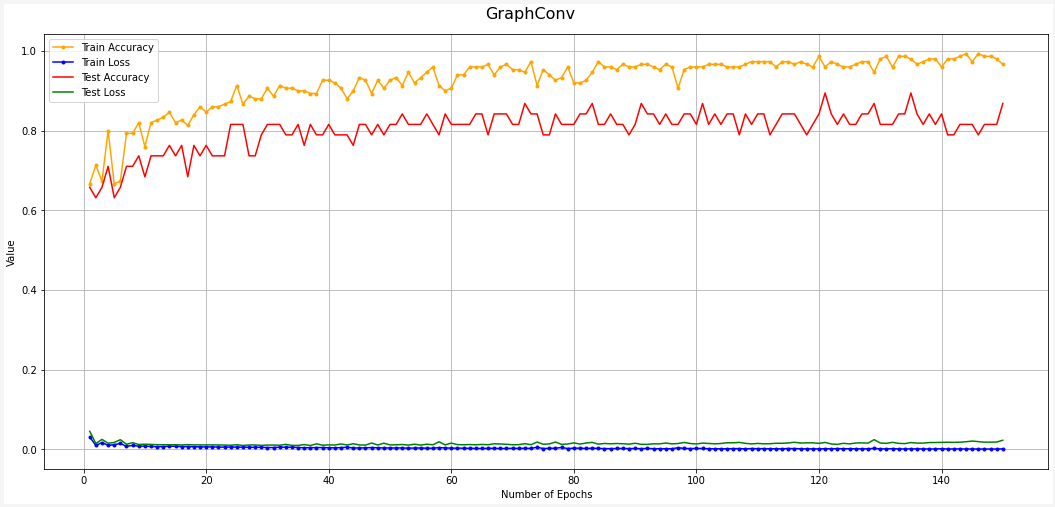

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=150, title='GraphConv')

In [ ]:
model = Graph_Conv3(hidden_channels=64)
print(model)

Graph_Conv3(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_GraphConv3 = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GraphConv3.train_and_evaluate(train_data_loader, test_data_loader,  n_epochs=150)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.7400, Train Loss: 0.0082, Test Accuracy: 0.6579, Test Loss: 0.0133
Epoch: 002, Train Accuracy: 0.6733, Train Loss: 0.0172, Test Accuracy: 0.6579, Test Loss: 0.0278
Epoch: 003, Train Accuracy: 0.7333, Train Loss: 0.0143, Test Accuracy: 0.6842, Test Loss: 0.0196
Epoch: 004, Train Accuracy: 0.7533, Train Loss: 0.0113, Test Accuracy: 0.6316, Test Loss: 0.0186
Epoch: 005, Train Accuracy: 0.6933, Train Loss: 0.0133, Test Accuracy: 0.6579, Test Loss: 0.0228
Epoch: 006, Train Accuracy: 0.7667, Train Loss: 0.0085, Test Accuracy: 0.7368, Test Loss: 0.0140
Epoch: 007, Train Accuracy: 0.7667, Train Loss: 0.0085, Test Accuracy: 0.7368, Test Loss: 0.0138
Epoch: 008, Train Accuracy: 0.7733, Train Loss: 0.0084, Test Accuracy: 0.6842, Test Loss: 0.0129
Epoch: 009, Train Accuracy: 0.7933, Train Loss: 0.0083, Test Accuracy: 0.6842, Test Loss: 0.0133
Epoch: 010, Train Accuracy: 0.7933, Train Loss: 0.0080, Test Accuracy: 0.6842, Test Loss: 0.012

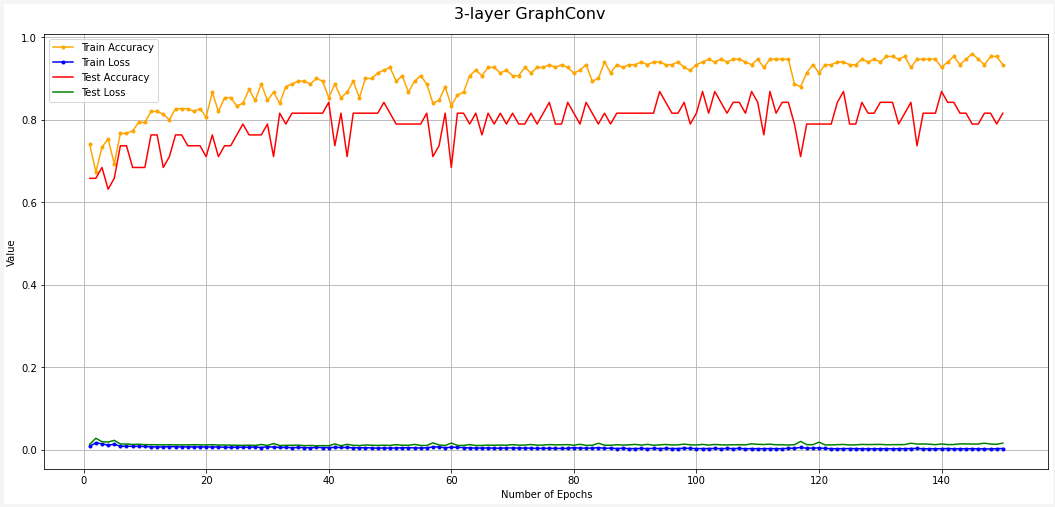

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=150, title='3-layer GraphConv')

In [ ]:
import pandas as pd

conclusion = pd.DataFrame([
    ['4-layer GCN (Agg=add)' ,0.8067, 0.0084, 0.7895, 0.0135, 95],
    ['4-layer GCN (Agg=max)' ,0.88, 0.0058, 0.7895, 0.0139, 69],
    ['4-layer GCN (Agg=mean)' ,0.8667, 0.0068, 0.7895, 0.0117, 91],
    ['4-layer GCN (Agg=[ add, max, mean ])' ,0.94, 0.0037, 0.8158, 0.0134, 63],
    ['4-layer GraphSage (Agg=defualt)' ,0.8733, 0.0063, 0.8421, 0.0125, 120],
    ['4-layer GraphConv (Agg=defualt)' ,0.98, 0.0012, 0.8947, 0.0170, 135],
    ['3-layer GraphConv (Agg=defualt)' ,0.9467, 0.0028, 0.8684, 0.0137, 112]
    ],
    columns=["Model Details","Train Accuracy", "Train loss", "Test Accuracy", "Test loss", 'Epoch with best result'])

conclusion = conclusion.set_index('Model Details')
conclusion.style.background_gradient(cmap="YlOrRd")

,Train Accuracy,Train loss,Test Accuracy,Test loss,Epoch with best result
Model Details,,,,,
4-layer GCN (Agg=add),0.806700,0.008400,0.789500,0.013500,95
4-layer GCN (Agg=max),0.880000,0.005800,0.789500,0.013900,69
4-layer GCN (Agg=mean),0.866700,0.006800,0.789500,0.011700,91
"4-layer GCN (Agg=[ add, max, mean ])",0.940000,0.003700,0.815800,0.013400,63
4-layer GraphSage (Agg=defualt),0.873300,0.006300,0.842100,0.012500,120
4-layer GraphConv (Agg=defualt),0.980000,0.001200,0.894700,0.017000,135
3-layer GraphConv (Agg=defualt),0.946700,0.002800,0.868400,0.013700,112
